In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import sqlite3

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///"+"hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
inspector = inspect(engine)
# reflect the tables
inspector.get_table_names()

['measurement', 'station']

In [6]:
# View all of the classes that automap found
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Use Inspector to print the column names and types frpm measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Use Inspector to print the column names and types frpm measurement table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = max(session.query(Measurement.date))
print(recent_date)

('2017-08-23',)


In [12]:
import datetime

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

end_Date = recent_date[0]

# Calculate the date one year from the last date in data set.
start_Date = str(datetime.datetime.strptime(end_Date, '%Y-%m-%d').date() - datetime.timedelta(days=365))

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
            filter(Measurement.date>=start_Date, Measurement.date<=end_Date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data_dict = {
            'ids': [result[0] for result in results],
            'station': [result[1] for result in results],
            'prcp': [result[3] for result in results],
            'tobs': [result[4] for result in results]
}

date = [result[2] for result in results]

data_df = pd.DataFrame(data_dict, index=date)


# Sort the dataframe by date
data_df = data_df.sort_index()
data_df.head(10)

,ids,station,prcp,tobs
2016-08-23,2364,USC00519397,0.00,81.0
2016-08-23,8825,USC00517948,NaN,80.0
2016-08-23,14608,USC00519281,1.79,77.0
2016-08-23,7331,USC00514830,0.05,80.0
2016-08-23,5091,USC00513117,0.15,76.0
2016-08-23,19202,USC00516128,0.70,74.0
2016-08-23,11851,USC00519523,0.02,80.0
2016-08-24,2365,USC00519397,0.08,79.0
2016-08-24,14609,USC00519281,2.15,77.0
2016-08-24,7332,USC00514830,2.28,80.0


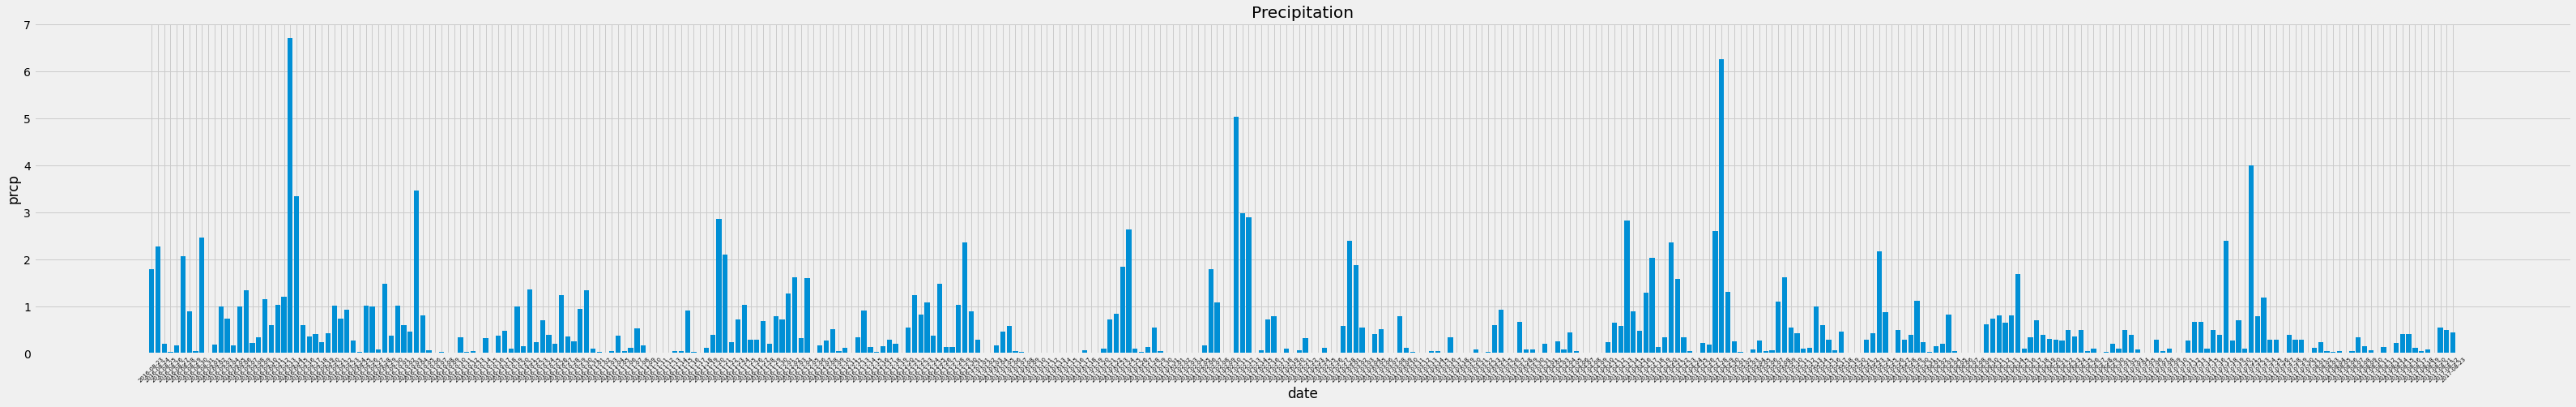

In [21]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(50,7))
plt.bar(data_df.index.values, data_df['prcp'])
ax.set_xlabel("date")
ax.set_ylabel("prcp")
plt.xticks(rotation='45',fontsize=7)
ax.set_title("Precipitation")
plt.show()

In [22]:
# creating year and month column to aggregate the data at year-month level
data_df = data_df.reset_index()
data_df['year'] = pd.DatetimeIndex(data_df['index']).year
data_df['month'] = pd.DatetimeIndex(data_df['index']).month

data_df['year_month'] = data_df['year'].map(str)+ '-' +data_df['month'].map(str)
data_df['year_month'] = pd.to_datetime(data_df['year_month'], format='%Y-%m').dt.strftime('%Y-%m')

data_df.head()

,index,ids,station,prcp,tobs,year,month,year_month
0,2016-08-23,2364,USC00519397,0.00,81.0,2016,8,2016-08
1,2016-08-23,8825,USC00517948,NaN,80.0,2016,8,2016-08
2,2016-08-23,14608,USC00519281,1.79,77.0,2016,8,2016-08
3,2016-08-23,7331,USC00514830,0.05,80.0,2016,8,2016-08
4,2016-08-23,5091,USC00513117,0.15,76.0,2016,8,2016-08


In [23]:
# calculating mean of prcp and tobs at year_month level
data_df_grouped = data_df.groupby('year_month').mean().loc[:,['prcp','tobs']]
data_df_grouped = data_df_grouped.reset_index()
data_df_grouped.head()

,year_month,prcp,tobs
0,2016-08,0.392642,78.135593
1,2016-09,0.285549,77.747368
2,2016-10,0.121620,77.196970
3,2016-11,0.120234,74.543011
4,2016-12,0.199494,71.130000


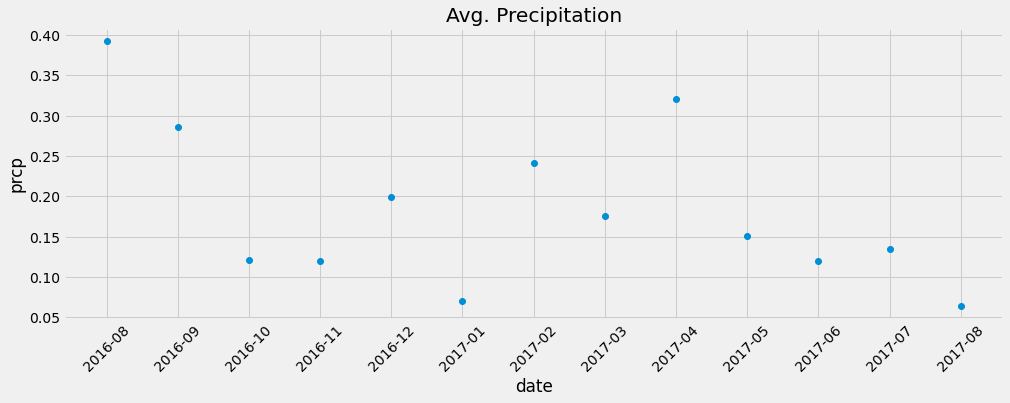

In [24]:
#Using matplotlib to build chart at aggregated level of prcp and tobs
data_df_grouped = data_df_grouped.sort_values('year_month')
fig, ax = plt.subplots(figsize=(15,5))
plt.plot_date(data_df_grouped['year_month'], data_df_grouped['prcp'])
ax.set_xlabel("date")
ax.set_ylabel("prcp")
plt.xticks(rotation='45')
ax.set_title("Avg. Precipitation")
plt.show()

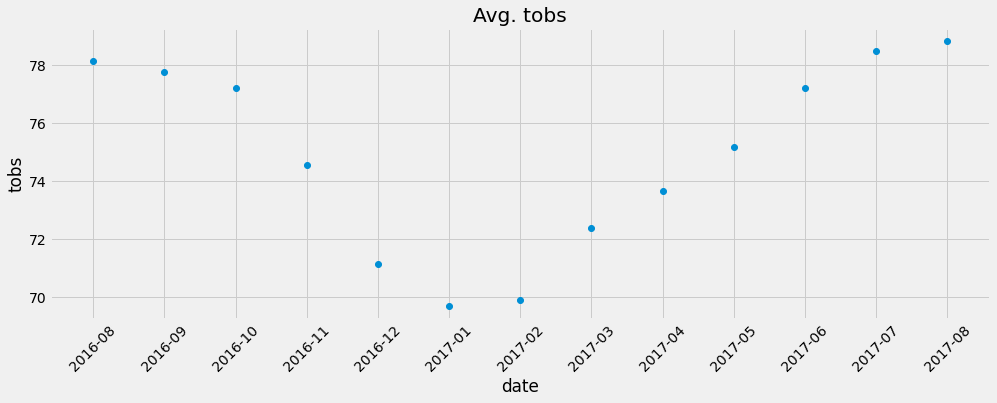

In [26]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot_date(data_df_grouped['year_month'], data_df_grouped['tobs'])
ax.set_xlabel("date")
ax.set_ylabel("tobs")
plt.xticks(rotation='45')
ax.set_title("Avg. tobs")
plt.show()

In [27]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data_df.describe()

,ids,prcp,tobs,year,month
count,2230.000000,2021.000000,2230.000000,2230.000000,2230.000000
mean,10158.570404,0.177279,74.590583,2016.626457,6.539013
std,5603.500203,0.461190,4.611667,0.483853,3.487857
min,2364.000000,0.000000,58.000000,2016.000000,1.000000
25%,5287.250000,0.000000,72.000000,2016.000000,4.000000
50%,8930.500000,0.020000,75.000000,2017.000000,7.000000
75%,14750.750000,0.130000,78.000000,2017.000000,10.000000
max,19550.000000,6.700000,87.000000,2017.000000,12.000000


# Exploratory Station Analysis

In [28]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(Station.station).group_by(Station.station).count()
print("Total number stations are", total_stations)

Total number stations are 9


In [32]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
res = session.query(Station.name,Station.station,func.count(Station.id)).\
        join(Measurement, Measurement.station==Station.station).\
        group_by(Station.name, Station.station).\
        order_by(func.count(Station.id).desc()).all()
res

[('WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 ('KANEOHE 838.1, HI US', 'USC00513117', 2709),
 ('WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 ('MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 'USC00514830', 2202),
 ('HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 ('PEARL CITY, HI US', 'USC00517948', 1372),
 ('UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [34]:
most_active_station = res[0][1]
most_active_station

'USC00519281'

In [35]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
res = session.query(Station.station,func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        join(Measurement, Measurement.station==Station.station).\
        filter(Station.station==most_active_station).\
        group_by(Station.station).all()
res

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
res = session.query(Station.station,func.max(Measurement.date), func.min(Measurement.date)).\
        join(Measurement, Measurement.station==Station.station).\
        filter(Station.station==most_active_station).\
        group_by(Station.station).all()
res

[('USC00519281', '2017-08-18', '2010-01-01')]

In [37]:
end_Date = res[0][1]
# Calculate the date one year from the last date in data set.
start_Date = str(datetime.datetime.strptime(end_Date, '%Y-%m-%d').date() - datetime.timedelta(days=365))
print(start_Date, end_Date)

2016-08-18 2017-08-18


In [38]:
res = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station==most_active_station,Measurement.date>=start_Date, Measurement.date<=end_Date).all()

In [39]:
#saving the query result in the pandas dataframe
data_dict2 = {
            'date': [result[0] for result in res],
            'tobs': [result[1] for result in res]
}

df = pd.DataFrame(data_dict2)
df.head()

,date,tobs
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0


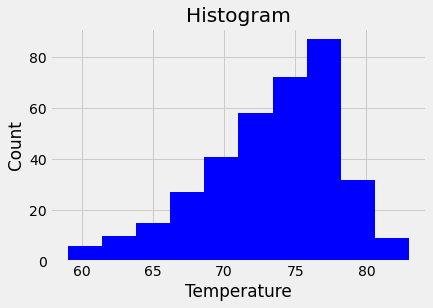

In [40]:
#histogram plot
num_bins = 15
x = df['tobs']
plt.hist(x, facecolor='blue')
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.title('Histogram')
plt.show()

# Close session

In [41]:
# Close Session
session.close()